# Introduction to LangGraph

LangGraph is a framework for creating applications using graph-based workflows. Each node represents a function or computational step, and edges define the flow between these nodes based on certain conditions.

## Key Features:
- State Management
- Flexible Routing
- Persistence
- Visualization

## Overview: Text Analysis Pipeline

In this tutorial, we'll demonstrate the power of LangGraph by building a multi-step text analysis pipeline. Our use case will focus on processing a given text through three key stages:

1. **Text Classification**: We'll categorize the input text into predefined categories (e.g., News, Blog, Research, or Other).
2. **Entity Extraction**: We'll identify and extract key entities such as persons, organizations, and locations from the text.
3. **Text Summarization**: Finally, we'll generate a concise summary of the input text.

This pipeline showcases how LangGraph can be used to create a modular, extensible workflow for natural language processing tasks. By the end of this tutorial, you'll understand how to construct a graph-based application that can be easily modified or expanded for various text analysis needs.

### Import Required Libraries
This cell imports all the necessary modules and classes for this program.

In [1]:
from typing import TypedDict, List
from langgraph.graph import StateGraph,START, END
from langchain_core.prompts import PromptTemplate
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

### Load Environment Variables


In [2]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv(dotenv_path="../.env", verbose=True)

# # Retrieve the key
# openai_key = os.getenv('OPENAI_API_KEY')

# # Check if it exists
# if openai_key:
#     print(f"API Key found: {openai_key}")
# else:
#     print("API Key not found. Please check your .env file.")

True

## Building the Text Processing Pipeline

### Define State and Initialize LLM
Here we define the State class to hold our workflow data and initialize the OpenAI model.

In [20]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str

llm = init_chat_model("openai:gpt-5-nano", temperature=0)

### Define Node Functions
These functions define the operations performed at each node of our graph: classification, entity extraction, and summarization.

In [21]:
def classification_node(state: State):
    """Classify text into: News, Blog, Research, or Other."""
    prompt = PromptTemplate(
        input_variables=["text"],
        template=(
            "Classify the following text into one of the categories: "
            "News, Blog, Research, or Other.\n\nText:{text}\n\nCategory:"
        ),
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    classification = llm.invoke([message]).content.strip()
    return {"classification": classification}

def entity_extraction_node(state: State):
    """Extract entities (Person, Organization, Location)."""
    prompt = PromptTemplate(
        input_variables=["text"],
        template=(
            "Extract all the entities (Person, Organization, Location) from the following text. "
            "Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"
        ),
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    entities_text = llm.invoke([message]).content.strip()
    # Be robust if model returns empty string
    entities = [e.strip() for e in entities_text.split(",") if e.strip()] if entities_text else []
    return {"entities": entities}

def summarization_node(state: State):
    """Summarize the text in one short sentence."""
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Summarize the following text in one short sentence.\n\nText:{text}\n\nSummary:",
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary = llm.invoke([message]).content.strip()
    return {"summary": summary}

### Create Tools and Build Workflow
This cell builds the StateGraph workflow.

In [14]:
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)

# Add edges to the graph
workflow.add_edge(START,"classification_node") # Set the entry point of the graph
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization")
workflow.add_edge("summarization", END)

# Compile the graph
app = workflow.compile()

## Visualizing the Workflow
This cell creates a visual representation of our workflow using Mermaid

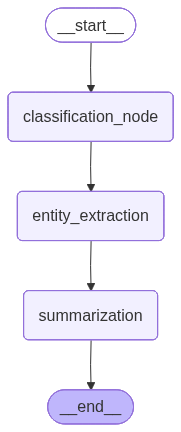

In [16]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Testing the Pipeline
This cell runs a sample text through our pipeline and displays the results.

In [19]:
sample_text = """
Latest release update from OpenAI : September 9, 2025
ChatGPT Voice Update
Last month we announced that everyone now has access to Advanced Voice Mode, with usage expanded from minutes per day to hours for Free users, and near-unlimited use for Plus.
We also shared that Standard Voice Mode would be retired following a 30-day sunset period. We've heard feedback that Standard Voice is special to some folks, and we want to make sure the transition feels right. To that end, we’re keeping Standard Voice available while we address some feedback from its users about Advanced Voice.
"""

state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])

Classification: News

Entities: ['OpenAI']

Summary: OpenAI will keep Standard Voice available while expanding Advanced Voice access to all users and addressing feedback on the transition.



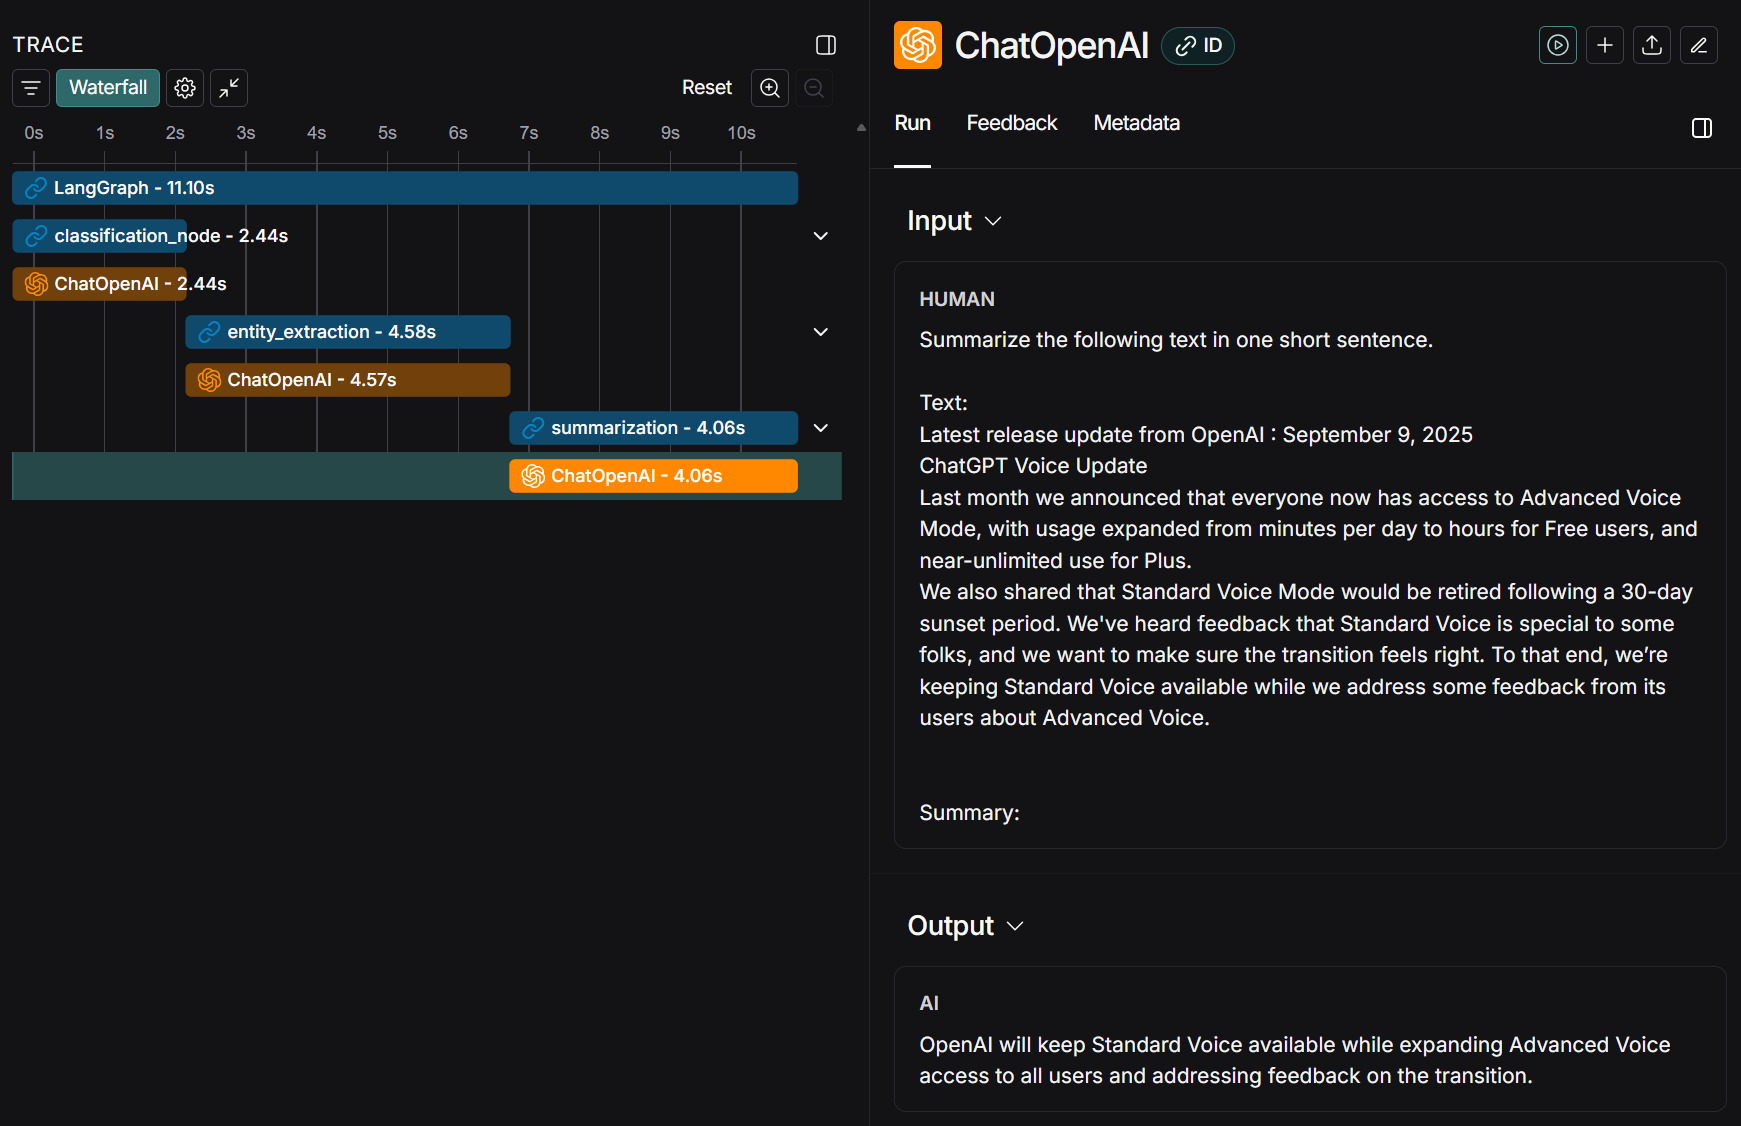

## Conclusion


- Explored LangGraph concepts
- Built a text processing pipeline
- Demonstrated LangGraph's use in data processing workflows
- Visualized the workflow using Mermaid

This example showcases how LangGraph can be used for tasks beyond conversational agents, providing a flexible framework for creating complex, graph-based workflows.